In [2]:
%cd /Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import h5py
import scipy.linalg
import math

/Users/masha/Documents/GSOC/GSoC-Quantum-Diffusion-Model


In [3]:
filename = "data/QG1_64x64_1k"
data_X = np.array(h5py.File(filename, "r")['X'])

print("Raw data shape:", data_X.shape)

data_X = data_X.astype(np.float32)

# log + normalize
data_X = np.log1p(data_X)
data_X = data_X / data_X.max()

# map to [-1, 1]
data_X = 2.0 * data_X - 1.0

Raw data shape: (1000, 64, 64)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

tensor_data = torch.tensor(data_X).unsqueeze(1)  # (N, 1, 64, 64)
dataset = TensorDataset(tensor_data)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Tensor data shape:", tensor_data.shape)

Tensor data shape: torch.Size([1000, 1, 64, 64])


In [5]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.lin = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.SiLU(),
            nn.Linear(dim * 4, dim)
        )

    def forward(self, t):
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, device=t.device) / half
        )
        args = t.unsqueeze(-1) * freqs.unsqueeze(0)
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return self.lin(emb)


class SmallConvField(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, time_emb_dim=64):
        super().__init__()
        self.time_emb = TimeEmbedding(time_emb_dim)
        self.time_proj = nn.Linear(time_emb_dim, base_ch)

        self.init_conv = nn.Conv2d(in_ch + 1, base_ch, 3, padding=1, padding_mode='circular')
        self.conv1 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')
        self.conv2 = nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular')

        self.mid = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU()
        )

        self.final = nn.Sequential(
            nn.Conv2d(base_ch, base_ch, 3, padding=1, padding_mode='circular'),
            nn.SiLU(),
            nn.Conv2d(base_ch, in_ch, 3, padding=1, padding_mode='circular')
        )

    def forward(self, x, t):
        B, C, H, W = x.shape
        t_channel = t.view(B, 1, 1, 1).expand(-1, 1, H, W)
        h = torch.cat([x, t_channel], dim=1)

        h = F.silu(self.init_conv(h))
        h = F.silu(self.conv1(h) + h)
        h = F.silu(self.conv2(h) + h)

        h = self.mid(h)

        t_emb = self.time_emb(t)
        t_proj = self.time_proj(t_emb).view(B, -1, 1, 1)
        h = h + t_proj

        return self.final(h)

def linear_mix(x0, x1, t):
    t = t.view(-1, 1, 1, 1)
    return (1.0 - t) * x0 + t * x1

In [6]:
def train_one_epoch(model, loader, optimizer, latent_std=0.5):
    model.train()
    total_loss = 0.0

    for (x0,) in loader:
        x0 = x0.to(device)
        B = x0.size(0)

        x1 = torch.randn_like(x0) * latent_std
        t = torch.rand(B, device=device)

        x_t = linear_mix(x0, x1, t)
        target_v = x1 - x0

        pred_v = model(x_t, t)
        loss = F.mse_loss(pred_v, target_v)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * B

    return total_loss / len(loader.dataset)

model = SmallConvField(
    in_ch=1,
    base_ch=64,
    time_emb_dim=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
epochs = 30
loss_history = []

for epoch in range(1, epochs + 1):
    loss = train_one_epoch(model, train_loader, optimizer)
    loss_history.append(loss)
    print(f"Epoch {epoch}: avg loss = {loss:.6f}")

Epoch 1: avg loss = 0.629472
Epoch 2: avg loss = 0.256982
Epoch 3: avg loss = 0.251807
Epoch 4: avg loss = 0.251105
Epoch 5: avg loss = 0.250258
Epoch 6: avg loss = 0.249475
Epoch 7: avg loss = 0.248092
Epoch 8: avg loss = 0.246093
Epoch 9: avg loss = 0.233224
Epoch 10: avg loss = 0.139121
Epoch 11: avg loss = 0.073256
Epoch 12: avg loss = 0.057699
Epoch 13: avg loss = 0.048433
Epoch 14: avg loss = 0.046625
Epoch 15: avg loss = 0.032888
Epoch 16: avg loss = 0.022774
Epoch 17: avg loss = 0.023678
Epoch 18: avg loss = 0.024592
Epoch 19: avg loss = 0.021995
Epoch 20: avg loss = 0.017020
Epoch 21: avg loss = 0.017623
Epoch 22: avg loss = 0.019419
Epoch 23: avg loss = 0.013598
Epoch 24: avg loss = 0.011210
Epoch 25: avg loss = 0.014018
Epoch 26: avg loss = 0.018212
Epoch 27: avg loss = 0.013063
Epoch 28: avg loss = 0.012366
Epoch 29: avg loss = 0.010737
Epoch 30: avg loss = 0.010567


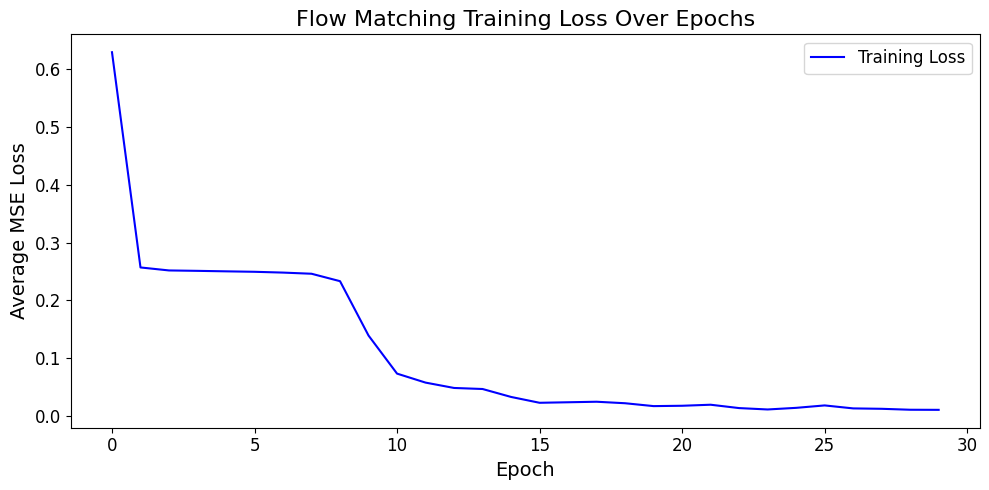

In [ ]:
plt.figure(figsize=(10, 5))

plt.plot(loss_history, label='Training Loss', color='blue')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Average Loss', fontsize=14)
plt.title('Flow Matching Training Loss Over Epochs', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [9]:
@torch.no_grad()
def rk4_integration(model, x_init, t0=1.0, t1=0.0, steps=80):
    model.eval()
    x = x_init.clone()
    B = x.size(0)

    dt = (t1 - t0) / steps
    t = t0

    for _ in range(steps):
        t_vec = torch.full((B,), t, device=x.device)

        k1 = model(x, t_vec)
        k2 = model(x + 0.5 * dt * k1, t_vec + 0.5 * dt)
        k3 = model(x + 0.5 * dt * k2, t_vec + 0.5 * dt)
        k4 = model(x + dt * k3, t_vec + dt)

        x = x + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        t = t + dt

    return x

@torch.no_grad()
def sample(model, n=16, steps=80, latent_std=0.5):
    z = torch.randn(n, 1, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x

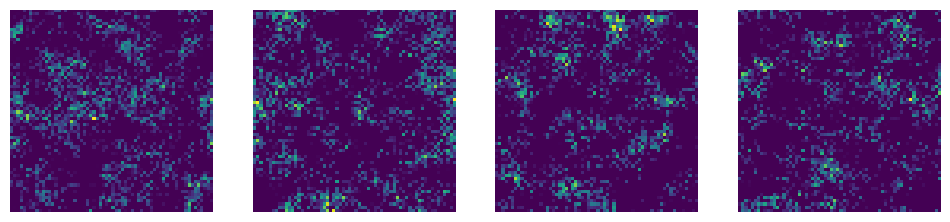

In [10]:
samples = sample(model, n=4)

fig, axs = plt.subplots(1, 4, figsize=(12, 3))
for i in range(4):
    img = (samples[i].clamp(-1, 1) + 1) / 2
    axs[i].imshow(img.squeeze().cpu())
    axs[i].axis("off")

plt.show()

In [18]:
n_samples = 100

@torch.no_grad()
def generate_samples(model, n_samples, steps=80, latent_std=0.2):
    model.eval()
    z = torch.randn(n_samples, 1, 64, 64, device=device) * latent_std
    x = rk4_integration(model, z, steps=steps)
    return x.cpu()

# real data
real_imgs = torch.tensor(data_X[:n_samples]).unsqueeze(1)

# generated data
fake_imgs = generate_samples(model, n_samples)

print(real_imgs.shape, fake_imgs.shape)

torch.Size([100, 1, 64, 64]) torch.Size([100, 1, 64, 64])


In [22]:
from skimage.metrics import structural_similarity as ssim

def compute_ssim(real, fake):
    real = real.squeeze(1).numpy()
    fake = fake.squeeze(1).numpy()

    scores = []
    for i in range(len(real)):
        s = ssim(
            real[i],
            fake[i],
            data_range=2.0  # because images are in [-1, 1]
        )
        scores.append(s)

    return np.mean(scores), np.std(scores)

def compute_fid(real, fake):
    """
    real, fake: (N, 1, 64, 64)
    """
    real = real.view(real.size(0), -1).numpy()
    fake = fake.view(fake.size(0), -1).numpy()

    mu_r = real.mean(axis=0)
    mu_f = fake.mean(axis=0)

    cov_r = np.cov(real, rowvar=False)
    cov_f = np.cov(fake, rowvar=False)

    diff = mu_r - mu_f
    covmean = scipy.linalg.sqrtm(cov_r @ cov_f)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff @ diff + np.trace(cov_r + cov_f - 2 * covmean)
    return float(fid)

ssim_mean, ssim_std = compute_ssim(real_imgs, fake_imgs)
print(f"SSIM: {ssim_mean:.6f} ± {ssim_std:.6f}")

fid_score = compute_fid(real_imgs, fake_imgs)
print(f"FID: {fid_score:.6f}")

SSIM: 0.984262 ± 0.003119
FID: 0.376359


/var/folders/27/76q8rfwn799g95yl3x7jwbnh0000gn/T/ipykernel_1277/3783458403.py:32: LinAlgWarning: Matrix is singular. The result might be inaccurate or the array might not have a square root.
  covmean = scipy.linalg.sqrtm(cov_r @ cov_f)


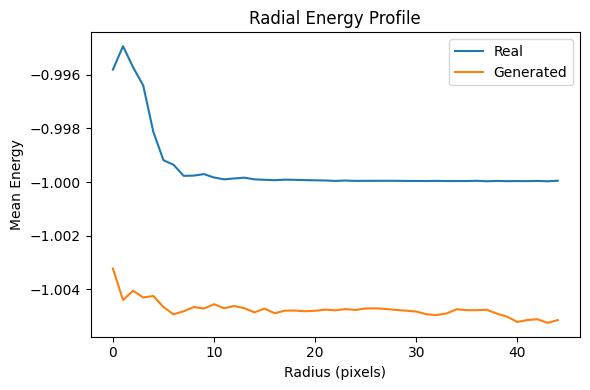

In [23]:
def radial_energy_profile(imgs):
    # imgs: (N, 1, 64, 64)
    N, _, H, W = imgs.shape
    cy, cx = H // 2, W // 2

    yy, xx = torch.meshgrid(
        torch.arange(H), torch.arange(W), indexing="ij"
    )
    r = torch.sqrt((yy - cy)**2 + (xx - cx)**2)
    r = r.to(imgs.device)

    max_r = int(r.max().item())
    profiles = []

    for img in imgs:
        prof = []
        for ri in range(max_r):
            mask = (r >= ri) & (r < ri + 1)
            prof.append(img[0][mask].mean().item())
        profiles.append(prof)

    return np.array(profiles)

def plot_radial_profiles(real, fake):
    rp_real = radial_energy_profile(real)
    rp_fake = radial_energy_profile(fake)

    mean_real = rp_real.mean(axis=0)
    mean_fake = rp_fake.mean(axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(mean_real, label="Real")
    plt.plot(mean_fake, label="Generated")
    plt.xlabel("Radius (pixels)")
    plt.ylabel("Mean Energy")
    plt.legend()
    plt.title("Radial Energy Profile")
    plt.tight_layout()
    plt.show()

plot_radial_profiles(real_imgs, fake_imgs)

Real energy: mean=-4095.4534, std=0.2426
Fake energy: mean=-4115.6006, std=2.1966


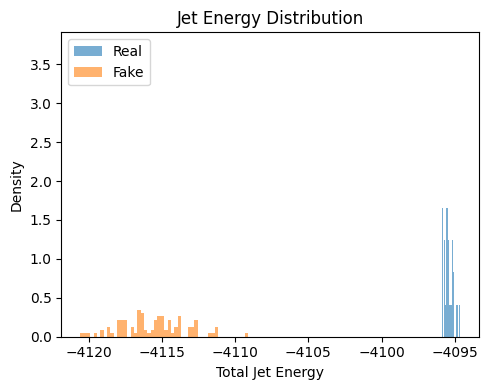

In [24]:
def jet_energy(imgs):
    # imgs: (N, 1, 64, 64)
    return imgs.sum(dim=(1, 2, 3)).numpy()

def compare_energy(real, fake):
    E_real = jet_energy(real)
    E_fake = jet_energy(fake)

    print(f"Real energy: mean={E_real.mean():.4f}, std={E_real.std():.4f}")
    print(f"Fake energy: mean={E_fake.mean():.4f}, std={E_fake.std():.4f}")

    plt.figure(figsize=(5, 4))
    plt.hist(E_real, bins=50, alpha=0.6, label="Real", density=True)
    plt.hist(E_fake, bins=50, alpha=0.6, label="Fake", density=True)
    plt.xlabel("Total Jet Energy")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Jet Energy Distribution")
    plt.tight_layout()
    plt.show()

compare_energy(real_imgs, fake_imgs)